# A Family Business Moving to a New Location
#### _Capstone Project, IBM Data Science Professional Certificate - The Battle of Neighborhoods (Week 2)_

Muhammad Faizan Siddiqui 
(09-May-2020)

## Table of Contents

* [Problem](#problem)
* [Approach](#approach)
* [Data Requirements and Sources](#data_requirements_and_sources)
* [Preparing the Environment](#preparing_the_environment)
* [Data Collection, Understanding & Preparation](#data_collection_understanding_preparation)
* [Analyzing Dataset](#analyzing_dataset)
* [Modeling the Data Using KMeans Clustering](#modeling_the_data_using_kmeans_clustering)
* [Finding the Health-and-Fitness Business Friendly Cities](#finding_the_business_friendly_cities)
* [Conclusion](#conclusion)

<a id='problem'></a>
## Problem

A Huntsville, Alabama based family considering relocating to a different city, most probably in another state, which is
lucrative for their family-run business. Moreover, rebuilding the business from scratch is a
gigantic task, and in their business, real estate is very important; therefore, they are also
looking for the city with relatively requires low investment in real estate. Finally, as the whole
family will be relocating along with the business, they would like to remain on the South or East side
and their elders are especially concerned about the changes in the weather.

<a id='approach'></a>
## Approach

We will address the problem in reverse order as it would simplify over process, reduce processing overhead and help in achieveing objective wihtin API limits.

* Create list of states on the South and East side.
* Shortlist those with similar weather conditions using KMeans Clustering. 
* Select states from these state with average low-cost of real eastate
* Finally, determine the cities that may have more potential for health-and-fitness business

<a id='data_requirements_and_sources'></a>
## Data Requirements and Sources

In line of our approach, following primary data sources will be used to obtain desired informatoin.

1. Downlaod <a href='https://github.com/cphalpert/census-regions'>census regions</a> data in CSV format to create list of states on the South and East side
2. Scrape state-wise <a href='https://www.currentresults.com/Weather/US/weather-averages-index.php'>average weather</a> data from the web-pages.
3. Downlaod real estate median home value dataset from Zillow via <a href='https://data.opendatasoft.com/explore/dataset/unites-states-home-values%40public/information/'>Opendatasoft: Data Network</a> in CSV format.
4. Use <a href='https://developer.foursquare.com/'>Foursquare API</a> to determine health-and-fitness related venues within the selected cities using JSON objects.


<a id='preparing_the_environment'></a>
## Preparing the Environment

Before we start work, let's install and import the required libraries, setup options and define some helper functions that will assist in later stages.

In [1]:
# Uncomment to install required packages

#!pip install beautifulsoup4
#!pip install lxml
#!pip install geopy
#!pip install geocoder
#!pip install folium
#!pip install seaborn

print('Installations done.')

Installations done.


In [2]:
# Importing necessary libraries

import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis

import requests # library to handle requests
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import seaborn as sns

import folium # map rendering library

# K-means for clustering 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# For error handling, progress tracking and API throtling
from random import randint
from time import sleep
import sys
import logging

# For web scrapping and location retrieval
from bs4 import BeautifulSoup
import geocoder as gc # import geocoder
from geopy.geocoders import Nominatim # we could've used geocoder (above) as well

# JSON and HTML formatting
import pprint

print('Libraries imported.')

Libraries imported.


In [3]:
# Adjust options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# So that more data can be printed on a single line
pp = pprint.PrettyPrinter(width=120)

print('Options adjusted.')

Options adjusted.


In [4]:
# Define helper functions

# Removes extra spaces and braces, converts to lower case and replaces with underscores
def standardize_columns(columns):
    return columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

# Removes non-ascii characters from the text, helpful in joins and for other operations
def fix_html_encoding(column):
    return column.str.encode(encoding="ascii", errors="ignore").str.decode(encoding="ascii", errors="ignore")

# Returns selected records from the states dataframe
def get_rec(state, count, df):
    return df[df['state']==state].sort_values(by=['population', 'density'], ascending=False).head(count)

# Borrow from New York city lab to explore all the neighborhoods in selected locations
def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

<a id='data_collection_understanding_preparation'></a>
## Data Collection, Understanding & Preparation

### Region-wise States List

Loading region-wise state list that was downloaded from <a href='https://github.com/cphalpert/census-regions'>Cphalpert(Github)</a> and peaking into the dataset.

In [5]:
states = pd.read_csv('us census bureau regions and divisions.csv')
states.head()

,State,State Code,Region,Division
0,Alaska,AK,West,Pacific
1,Alabama,AL,South,East South Central
2,Arkansas,AR,South,West South Central
3,Arizona,AZ,West,Mountain
4,California,CA,West,Pacific


Standardizing column names using the help function and removing the columns that are not needed.

In [6]:
states.columns = standardize_columns(states.columns)

states.drop('division', axis=1, inplace=True)
states['region'].value_counts()

South        17
West         13
Midwest      12
Northeast     9
Name: region, dtype: int64

Filtering data for northeast and south regions while ensuring our current, Alabama, remains in the dataset. 

In [7]:
states=states[(states['region']=='Northeast') | (states['region']=='South') | (states['state']=='Alabama')].reset_index(drop=True)
states

,state,state_code,region
0,Alabama,AL,South
1,Arkansas,AR,South
2,Connecticut,CT,Northeast
3,District of Columbia,DC,South
4,Delaware,DE,South
5,Florida,FL,South
6,Georgia,GA,South
7,Kentucky,KY,South
8,Louisiana,LA,South
9,Massachusetts,MA,Northeast


### Weather Data

Let's scrape the average wheather data from <a href='https://www.currentresults.com/Weather/US/weather-averages-index.php'>Current Results</a> website.

In [8]:
# Preparing list of pages that we wil read to collect weather data
url_list = [
    'https://www.currentresults.com/Weather/US/average-annual-state-precipitation.php',
    'https://www.currentresults.com/Weather/US/average-snowfall-by-state.php',
    'https://www.currentresults.com/Weather/US/annual-average-humidity-by-state.php',
    'https://www.currentresults.com/Weather/US/average-annual-state-sunshine.php',
    'https://www.currentresults.com/Weather/US/average-annual-state-temperatures.php'
]

weather=pd.DataFrame()
for url in url_list:
    # Create request object, read page directly into Pandas dataframe
    table = pd.read_html(requests.get(url).text,)
    # Extract the three data tables and combine the data
    table = pd.concat([table[0], table[1], table[2]]).reset_index(drop=True)
    # Standardizing columns names using helper function
    table.columns = standardize_columns(table.columns)
    # Fixing non-ascii characters to avoid problems while joining tables
    table['state']=fix_html_encoding(table['state'])

    if weather.empty == True:
        weather=table
    else:
        # Merge all tables in a single dataset
        weather=weather.merge(table, on='state', how='left')

weather.head()

,state,inches_x,milli­metres,rank_x,days,place_x,inches_y,cen­ti­me­tres,place_y,morn­ing,after­noon,place,%_sun,total_hours,clear_days,avg_°f,avg_°c,rank_y
0,Alabama,58.3,1480,4,0.8,Birming­ham,1.6,4.1,Birmingham,84,52,Birmingham,58,2641,99,62.8,17.1,7
1,Alaska,22.5,572,39,48.0,Anchor­age,74.5,189.2,Anchorage,77,64,Anchorage,41,2061,61,26.6,-3.0,50
2,Arizona,13.6,345,47,0.3,Tucson,0.3,0.8,Tucson,53,25,Tucson,85,3806,193,60.3,15.7,10
3,Arkansas,50.6,1284,8,3.8,Fort Smith,5.2,13.2,Fort Smith,85,49,Fort Smith,61,2771,123,60.4,15.8,9
4,California,22.2,563,40,0.0,San Diego,0.0,0.0,San Diego,76,62,San Diego,68,3055,146,59.4,15.2,12


Removing extra columns that will not be required during analysis.

In [9]:
weather=weather[weather.columns[~weather.columns.str.contains('place|rank|inches|°f')]]
weather.head(10)

,state,milli­metres,days,cen­ti­me­tres,morn­ing,after­noon,%_sun,total_hours,clear_days,avg_°c
0,Alabama,1480,0.8,4.1,84,52,58,2641,99,17.1
1,Alaska,572,48.0,189.2,77,64,41,2061,61,-3.0
2,Arizona,345,0.3,0.8,53,25,85,3806,193,15.7
3,Arkansas,1284,3.8,13.2,85,49,61,2771,123,15.8
4,California,563,0.0,0.0,76,62,68,3055,146,15.2
5,Colorado,405,19.1,48.5,60,35,71,3204,136,7.3
6,Connecticut,1279,20.1,102.9,79,52,56,2585,82,9.4
7,Delaware,1160,11.8,51.3,79,54,–,–,97,12.9
8,Florida,1385,0.0,0.0,87,57,66,2927,101,21.5
9,Georgia,1287,0.7,1.8,86,50,66,2986,112,17.5


### State-wise Home Values

Loading the real estate median home value dataset from Zillow via <a href='https://data.opendatasoft.com/explore/dataset/unites-states-home-values%40public/information/'>Opendatasoft: Data Network</a>.

Since the dataset is huge, we will only read required columns.

In [10]:
# The file is not commaseparated, so defining the correct delimiter
home_values = pd.read_csv('unites-states-home-values.csv', sep=';', usecols=['State', 'Home value ($ per m2)'])
home_values.columns = standardize_columns(home_values.columns)
home_values.head()

,state,home_value_$_per_m2
0,NY,89
1,NY,130
2,NY,65
3,WV,28
4,WV,43


We only need average values and column names needed to be renamed to match our naming convention.

In [11]:
home_values=home_values.groupby('state').mean().reset_index().rename(columns={'state':'state_code', 'home_value_$_per_m2':'home_value'})
home_values.head()

,state_code,home_value
0,AK,199.971200
1,AL,86.419470
2,AR,74.793365
3,AZ,229.199801
4,CA,526.929550


### Preparing Dataset for The Model

Merging region-wise state list, weather data and home value in a single dataset and fixing the non-ascii characters in the column names.

In [12]:
states_data=states.merge(weather, on='state', how='left').merge(home_values, on='state_code', how='left')
states_data.columns = fix_html_encoding(states_data.columns)
states_data.head()

,state,state_code,region,millimetres,days,centimetres,morning,afternoon,%_sun,total_hours,clear_days,avg_c,home_value
0,Alabama,AL,South,1480.0,0.8,4.1,84.0,52.0,58,2641,99.0,17.1,86.419470
1,Arkansas,AR,South,1284.0,3.8,13.2,85.0,49.0,61,2771,123.0,15.8,74.793365
2,Connecticut,CT,Northeast,1279.0,20.1,102.9,79.0,52.0,56,2585,82.0,9.4,230.990937
3,District of Columbia,DC,South,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,536.031359
4,Delaware,DE,South,1160.0,11.8,51.3,79.0,54.0,–,–,97.0,12.9,390.033860


Checking for datatypes. Some features need fixing to correct numberic types.

In [13]:
states_data.dtypes

state           object
state_code      object
region          object
millimetres    float64
days           float64
centimetres    float64
morning        float64
afternoon      float64
%_sun           object
total_hours     object
clear_days     float64
avg_c          float64
home_value     float64
dtype: object

Ensuring everything is fixed.

In [14]:
states_data[['millimetres', 'days', 'centimetres',
       'morning', 'afternoon', '%_sun', 'total_hours', 'clear_days', 'avg_c',
       'home_value']] = states_data[['millimetres', 'days', 'centimetres',
       'morning', 'afternoon', '%_sun', 'total_hours', 'clear_days', 'avg_c',
       'home_value']].apply(pd.to_numeric, errors='coerce')

states_data.dtypes

state           object
state_code      object
region          object
millimetres    float64
days           float64
centimetres    float64
morning        float64
afternoon      float64
%_sun          float64
total_hours    float64
clear_days     float64
avg_c          float64
home_value     float64
dtype: object

Droping rows containing null values.

In [15]:
print (states_data.shape)
states_data=states_data.dropna().reset_index(drop=True)
print (states_data.shape)
states_data

(26, 13)
(23, 13)


,state,state_code,region,millimetres,days,centimetres,morning,afternoon,%_sun,total_hours,clear_days,avg_c,home_value
0,Alabama,AL,South,1480.0,0.8,4.1,84.0,52.0,58.0,2641.0,99.0,17.1,86.419470
1,Arkansas,AR,South,1284.0,3.8,13.2,85.0,49.0,61.0,2771.0,123.0,15.8,74.793365
2,Connecticut,CT,Northeast,1279.0,20.1,102.9,79.0,52.0,56.0,2585.0,82.0,9.4,230.990937
3,Florida,FL,South,1385.0,0.0,0.0,87.0,57.0,66.0,2927.0,101.0,21.5,320.272950
4,Georgia,GA,South,1287.0,0.7,1.8,86.0,50.0,66.0,2986.0,112.0,17.5,119.665394
5,Kentucky,KY,South,1242.0,11.8,31.8,79.0,55.0,56.0,2514.0,93.0,13.1,79.535841
6,Louisiana,LA,South,1528.0,0.1,0.0,87.0,61.0,57.0,2649.0,101.0,19.1,210.489133
7,Massachusetts,MA,Northeast,1211.0,22.4,111.3,75.0,59.0,58.0,2634.0,98.0,8.8,285.895846
8,Maryland,MD,South,1131.0,9.6,51.3,77.0,52.0,57.0,2582.0,105.0,12.3,267.582460
9,Maine,ME,Northeast,1072.0,27.8,157.0,82.0,61.0,57.0,2513.0,101.0,5.0,320.398009


Persisting data, incase we might need to use it later.

In [16]:
states_data.to_csv('States_Data.csv', header=True, index=False)
#states_data = pd.read_csv('States_Data.csv') 

<a id='analyzing_dataset'></a>
## Analyzing Dataset

Looking for anomalies in data.

In [17]:
states_data.describe()

,millimetres,days,centimetres,morning,afternoon,%_sun,total_hours,clear_days,avg_c,home_value
count,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000
mean,1211.130435,13.847826,62.460870,82.217391,54.217391,58.521739,2649.130435,100.695652,13.060870,219.671588
std,183.850064,17.447997,80.619323,4.022172,4.155572,5.106765,215.433876,18.692329,4.602543,138.274729
min,734.000000,0.000000,0.000000,75.000000,48.000000,46.000000,2120.000000,58.000000,5.000000,73.488263
25%,1096.000000,1.050000,3.950000,79.000000,52.000000,56.000000,2516.500000,93.500000,9.350000,109.318054
50%,1218.000000,6.200000,26.200000,83.000000,53.000000,58.000000,2634.000000,101.000000,13.100000,201.206808
75%,1285.500000,19.750000,94.400000,84.500000,57.500000,61.000000,2798.500000,110.000000,17.000000,279.331649
max,1528.000000,66.400000,314.500000,91.000000,61.000000,68.000000,3089.000000,139.000000,21.500000,673.798746


Looks good! Lets generate histogram to identify any irrelevant/non-changing features.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000257A2BF2048>,
      dtype=object)

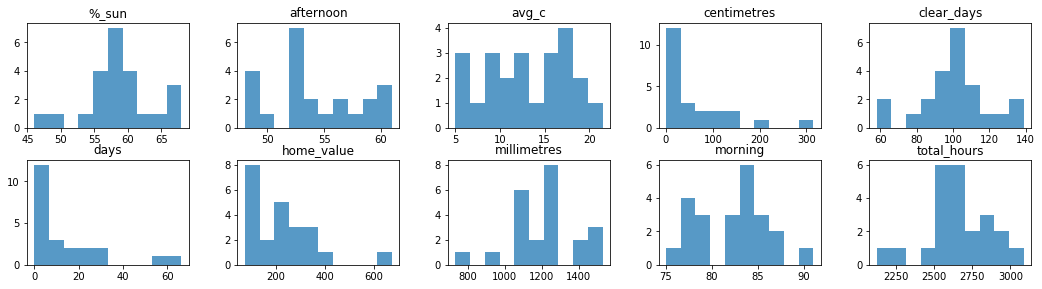

In [18]:
states_data.hist(figsize=(18,12), bins=10, grid=False, alpha=0.75, layout=(5,5))

Though, correlation within features is not a major problem for Clustering, let's have a look at our dataset.

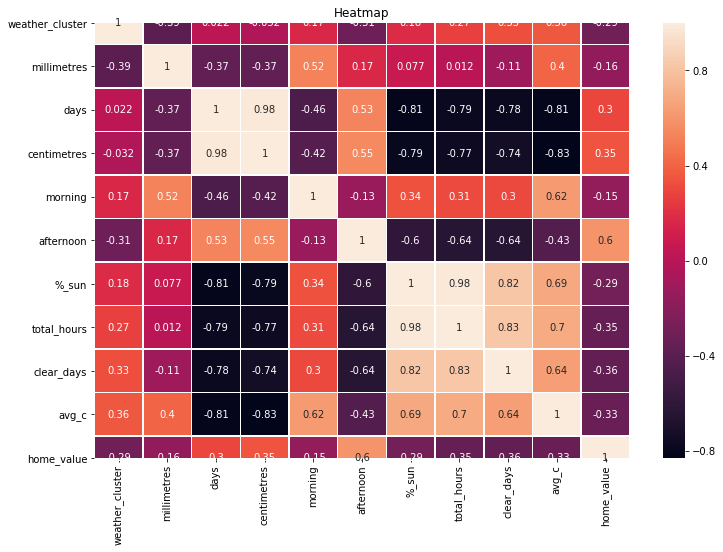

In [62]:
corr=states_data.corr()
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title("Heatmap")
sns.heatmap(corr, ax=ax, annot=True, linewidths=.5)

There's strong relationship between some attributes e.g., %sun, number of days ice falls and amount of ice etc. but that's not expected to hurt the model.

<a id='modeling_the_data_using_kmeans_clustering'></a>
## Modeling the Data Using KMeans Clustering 

Extracting weather data for clustering.

In [20]:
X = states_data.values[:,3:12]
X

array([[1480.0, 0.8, 4.1, 84.0, 52.0, 58.0, 2641.0, 99.0, 17.1],
       [1284.0, 3.8, 13.2, 85.0, 49.0, 61.0, 2771.0, 123.0, 15.8],
       [1279.0, 20.1, 102.9, 79.0, 52.0, 56.0, 2585.0, 82.0, 9.4],
       [1385.0, 0.0, 0.0, 87.0, 57.0, 66.0, 2927.0, 101.0, 21.5],
       [1287.0, 0.7, 1.8, 86.0, 50.0, 66.0, 2986.0, 112.0, 17.5],
       [1242.0, 11.8, 31.8, 79.0, 55.0, 56.0, 2514.0, 93.0, 13.1],
       [1528.0, 0.1, 0.0, 87.0, 61.0, 57.0, 2649.0, 101.0, 19.1],
       [1211.0, 22.4, 111.3, 75.0, 59.0, 58.0, 2634.0, 98.0, 8.8],
       [1131.0, 9.6, 51.3, 77.0, 52.0, 57.0, 2582.0, 105.0, 12.3],
       [1072.0, 27.8, 157.0, 82.0, 61.0, 57.0, 2513.0, 101.0, 5.0],
       [1499.0, 0.6, 2.3, 91.0, 54.0, 61.0, 2720.0, 111.0, 17.4],
       [1279.0, 3.9, 19.3, 83.0, 52.0, 60.0, 2651.0, 109.0, 15.0],
       [1103.0, 29.8, 154.4, 84.0, 53.0, 54.0, 2519.0, 90.0, 6.6],
       [1196.0, 8.7, 41.9, 83.0, 59.0, 56.0, 2499.0, 94.0, 11.5],
       [1062.0, 66.4, 314.5, 82.0, 61.0, 46.0, 2120.0, 63.0, 7.4],
 

Handling NaN and scaling for the algorithm.

In [21]:
# Replacing and NaN with zero and infinity with large finite numbers.
X = np.nan_to_num(X)
# Scaling data for ML
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet

array([[ 1.49530725e+00, -7.64619118e-01, -7.40176318e-01,
         4.53156263e-01, -5.45587179e-01, -1.04462422e-01,
        -3.85880074e-02, -9.27525660e-02,  8.97310253e-01],
       [ 4.05261149e-01, -5.88815322e-01, -6.24763293e-01,
         7.07365874e-01, -1.28373454e+00,  4.96196506e-01,
         5.78407405e-01,  1.22005298e+00,  6.08509644e-01],
       [ 3.77453851e-01,  3.66385302e-01,  5.12879381e-01,
        -8.17891792e-01, -5.45587179e-01, -5.04901708e-01,
        -3.04370646e-01, -1.02265650e+00, -8.13277969e-01],
       [ 9.66968577e-01, -8.11500130e-01, -7.92175593e-01,
         1.21578510e+00,  6.84658420e-01,  1.49729472e+00,
         1.31880190e+00,  1.66478965e-02,  1.87478924e+00],
       [ 4.21945528e-01, -7.70479244e-01, -7.69346643e-01,
         9.61575485e-01, -1.03768542e+00,  1.49729472e+00,
         1.59882289e+00,  6.18350440e-01,  9.86171979e-01],
       [ 1.71679842e-01, -1.20005200e-01, -3.88864143e-01,
        -8.17891792e-01,  1.92560181e-01, -5.049017

Verifying the number of records and columns.

In [22]:
Clus_dataSet.shape

(23, 9)

Iterate to find the optimal number of clusters.

In [23]:
Sum_of_squared_distances = []
labels=[]
K = range(1,15)
for k in K:
    k_means = KMeans(init = "k-means++", n_clusters = k, n_init = 12)
    k_means.fit(Clus_dataSet)
    # Capturing within-cluster sum-of-squares, will help in selecting the optimal value for k
    Sum_of_squared_distances.append(k_means.inertia_)
    # Saving the labels for later use
    labels.append(k_means.labels_)

labels

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0]),
 array([0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,
        1]),
 array([1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 2, 1, 0, 0, 1, 1, 1, 1,
        2]),
 array([1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 2, 3, 0, 0, 1, 1, 3, 1,
        2]),
 array([3, 1, 2, 3, 1, 2, 3, 2, 2, 2, 3, 1, 2, 2, 0, 4, 2, 2, 1, 3, 4, 1,
        0]),
 array([4, 4, 0, 1, 4, 0, 1, 0, 0, 5, 1, 4, 5, 0, 2, 3, 0, 0, 4, 4, 3, 4,
        2]),
 array([5, 6, 2, 0, 6, 2, 0, 2, 2, 1, 0, 5, 1, 5, 3, 4, 2, 2, 6, 5, 4, 6,
        3]),
 array([6, 2, 3, 7, 2, 3, 0, 3, 3, 1, 7, 6, 1, 3, 4, 5, 3, 3, 2, 6, 5, 2,
        4]),
 array([8, 4, 5, 0, 4, 1, 0, 5, 1, 6, 0, 8, 6, 1, 7, 2, 5, 5, 4, 8, 2, 4,
        3]),
 array([6, 3, 1, 0, 3, 1, 7, 1, 1, 8, 0, 6, 8, 1, 5, 9, 1, 1, 3, 6, 4, 3,
        2]),
 array([ 7,  1,  8,  4,  1,  8,  9,  2,  8, 10,  4,  7,  0,  5,  3,  6,  8,
         2,  1,  7,  6,  1,  3]),
 array([ 1,  2,  0, 

Using Elbow method, heuristic based approach to identify the optimal value of 'k'

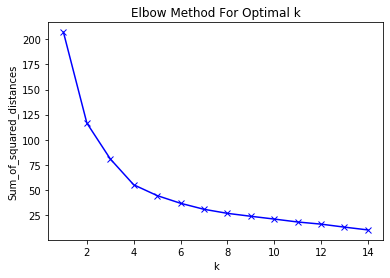

In [24]:
#Plot the intertia against the value of k
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Inserting the labels for the optimal value of 'k' (=4) into the dataset.

In [25]:
labels[3]

array([1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 2, 3, 0, 0, 1, 1, 3, 1,
       2])

In [26]:
optimal_cluster=4
#states_data.drop(columns=['weather_cluster'], inplace=True)
states_data.insert(3,column='weather_cluster', value=pd.DataFrame(labels[optimal_cluster-1]))
states_data

,state,state_code,region,weather_cluster,millimetres,days,centimetres,morning,afternoon,%_sun,total_hours,clear_days,avg_c,home_value
0,Alabama,AL,South,1,1480.0,0.8,4.1,84.0,52.0,58.0,2641.0,99.0,17.1,86.419470
1,Arkansas,AR,South,1,1284.0,3.8,13.2,85.0,49.0,61.0,2771.0,123.0,15.8,74.793365
2,Connecticut,CT,Northeast,0,1279.0,20.1,102.9,79.0,52.0,56.0,2585.0,82.0,9.4,230.990937
3,Florida,FL,South,1,1385.0,0.0,0.0,87.0,57.0,66.0,2927.0,101.0,21.5,320.272950
4,Georgia,GA,South,1,1287.0,0.7,1.8,86.0,50.0,66.0,2986.0,112.0,17.5,119.665394
5,Kentucky,KY,South,0,1242.0,11.8,31.8,79.0,55.0,56.0,2514.0,93.0,13.1,79.535841
6,Louisiana,LA,South,1,1528.0,0.1,0.0,87.0,61.0,57.0,2649.0,101.0,19.1,210.489133
7,Massachusetts,MA,Northeast,0,1211.0,22.4,111.3,75.0,59.0,58.0,2634.0,98.0,8.8,285.895846
8,Maryland,MD,South,0,1131.0,9.6,51.3,77.0,52.0,57.0,2582.0,105.0,12.3,267.582460
9,Maine,ME,Northeast,0,1072.0,27.8,157.0,82.0,61.0,57.0,2513.0,101.0,5.0,320.398009


Summarizing the data within the clusters.

In [27]:
states_data.groupby('weather_cluster').mean()

,millimetres,days,centimetres,morning,afternoon,%_sun,total_hours,clear_days,avg_c,home_value
weather_cluster,,,,,,,,,,
0,1171.222222,18.70,89.788889,79.333333,55.777778,56.666667,2562.888889,94.222222,9.566667,287.465079
1,1350.700000,2.25,8.420000,85.700000,52.900000,61.200000,2751.000000,107.300000,16.730000,161.738764
2,1073.500000,60.40,260.350000,79.500000,59.500000,47.500000,2207.500000,60.500000,6.750000,294.410872
3,830.500000,3.45,11.800000,80.500000,48.500000,64.500000,2969.500000,137.000000,16.750000,129.525712


Now, let's visualize the resulting clusters over the USA map.

In [28]:
# Get the coordinates of USA
address = 'United States of America'

geolocator = Nominatim(user_agent="usa_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of USA are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of USA are 39.7837304, -100.4458825.


Generating choropleth map using folium library.

In [29]:
# Using the USA GEO JSON
usa_geo = r'us-states.json' # geojson file

# Using customer bins
bins = [float(i) for i in list(range(0,5))]

# create a plain usa map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=4, tiles='Mapbox Bright')

# generate choropleth map using the custer
folium.Choropleth(
    geo_data=usa_geo,
    name='choropleth',
    data=states_data,
    columns=['state', 'weather_cluster'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.4,
    legend_name='States With Similar Weather',
    bins=bins,
    reset=True
).add_to(map_clusters)
folium.LayerControl().add_to(map_clusters)

# display map       
map_clusters

Selecting the cluster that contains Alabama state

In [30]:
target_cluster_num=states_data.loc[states_data['state']=='Alabama','weather_cluster'][0]
target_cluster=states_data[states_data['weather_cluster'] == target_cluster_num]
target_cluster

,state,state_code,region,weather_cluster,millimetres,days,centimetres,morning,afternoon,%_sun,total_hours,clear_days,avg_c,home_value
0,Alabama,AL,South,1,1480.0,0.8,4.1,84.0,52.0,58.0,2641.0,99.0,17.1,86.419470
1,Arkansas,AR,South,1,1284.0,3.8,13.2,85.0,49.0,61.0,2771.0,123.0,15.8,74.793365
3,Florida,FL,South,1,1385.0,0.0,0.0,87.0,57.0,66.0,2927.0,101.0,21.5,320.272950
4,Georgia,GA,South,1,1287.0,0.7,1.8,86.0,50.0,66.0,2986.0,112.0,17.5,119.665394
6,Louisiana,LA,South,1,1528.0,0.1,0.0,87.0,61.0,57.0,2649.0,101.0,19.1,210.489133
10,Mississippi,MS,South,1,1499.0,0.6,2.3,91.0,54.0,61.0,2720.0,111.0,17.4,98.970713
11,North Carolina,NC,South,1,1279.0,3.9,19.3,83.0,52.0,60.0,2651.0,109.0,15.0,132.396774
18,South Carolina,SC,South,1,1264.0,0.3,1.3,86.0,49.0,64.0,2826.0,115.0,16.9,208.765875
19,Tennessee,TN,South,1,1376.0,6.2,16.0,84.0,53.0,56.0,2510.0,102.0,14.2,92.846516
21,Virginia,VA,South,1,1125.0,6.1,26.2,84.0,52.0,63.0,2829.0,100.0,12.8,272.767451


The histogram for 'home_value' shows that we've four states in the first and the low cost bin.

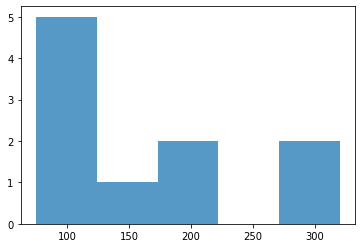

In [31]:
target_cluster['home_value'].hist(bins=5, grid=False, alpha=0.75)

Selecting the four states with low median cost of real-estate.

In [32]:
selected_states=target_cluster.sort_values(by=['home_value']).head(4)[['state', 'state_code', 'region']].reset_index(drop=True)
selected_states

,state,state_code,region
0,Arkansas,AR,South
1,Alabama,AL,South
2,Tennessee,TN,South
3,Mississippi,MS,South


<a id='finding_the_business_friendly_cities'></a>
## Finding the Health-and-Fitness Business Friendly Cities

### City-wise State List with Additional Helpful Features

Load the list of top cities for each state and selet only the required columns.

In [33]:
# Read CSV in Dataframe
state_cities = pd.read_csv('uscities.csv', usecols=['city_ascii', 'state_name', 'lat', 'lng', 'population','density', 'ranking'])
state_cities.columns = fix_html_encoding(standardize_columns(state_cities.columns))

# Rename the cities
state_cities.rename(columns={'city_ascii':'city', 'state_name':'state'}, inplace=True)

# Ensure datatypes are correct.
state_cities.dtypes
state_cities[['lat', 'lng', 'population','density', 'ranking']] = state_cities[['lat', 'lng', 'population','density', 'ranking']].apply(pd.to_numeric, errors='coerce')
state_cities.dtypes

# Drop records with null values
print (state_cities.shape)
state_cities=state_cities.dropna()
print (state_cities.shape)

state_cities.head()

(28889, 7)
(28889, 7)


,city,state,lat,lng,population,density,ranking
0,South Creek,Washington,46.9994,-122.3921,2500.0,125.0,3
1,Roslyn,Washington,47.2507,-121.0989,947.0,84.0,3
2,Sprague,Washington,47.3048,-117.9713,441.0,163.0,3
3,Gig Harbor,Washington,47.3352,-122.5968,9507.0,622.0,3
4,Lake Cassidy,Washington,48.0639,-122.0920,3591.0,131.0,3


Merge the data with the states we've shortlisted base on weather clusters and real-estate value.

In [34]:
selected_states=selected_states.merge(state_cities, on='state', how='left')
selected_states.head()

,state,state_code,region,city,lat,lng,population,density,ranking
0,Arkansas,AR,South,McDougal,36.4365,-90.3907,171.0,177.0,3
1,Arkansas,AR,South,McAlmont,34.7926,-92.1959,1704.0,423.0,3
2,Arkansas,AR,South,Paris,35.2899,-93.7236,3020.0,275.0,3
3,Arkansas,AR,South,Crawfordsville,35.2267,-90.3241,467.0,322.0,3
4,Arkansas,AR,South,Gravette,36.4291,-94.3713,3304.0,83.0,3


Looking at the summary information, seems like we've huge list of cities.

In [35]:
selected_states.describe(include='all')

,state,state_code,region,city,lat,lng,population,density,ranking
count,1908,1908,1908,1908,1908.000000,1908.000000,1.908000e+03,1908.000000,1908.000000
unique,4,4,1,1733,NaN,NaN,NaN,NaN,NaN
top,Alabama,AL,South,Decatur,NaN,NaN,NaN,NaN,NaN
freq,584,584,1908,4,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,34.178479,-88.757937,7.887828e+03,197.211740,2.988994
std,NaN,NaN,NaN,NaN,1.652973,2.868442,4.769413e+04,181.762571,0.113967
min,NaN,NaN,NaN,NaN,30.249200,-94.588900,9.000000e+00,2.000000,1.000000
25%,NaN,NaN,NaN,NaN,33.134675,-90.887825,3.857500e+02,70.000000,3.000000
50%,NaN,NaN,NaN,NaN,34.379650,-88.520350,1.059000e+03,148.000000,3.000000
75%,NaN,NaN,NaN,NaN,35.536375,-86.495450,3.304000e+03,267.000000,3.000000


Let's check, what if we select only top 1 & 2 cities from the dataset? It brings down number of cities to 29.

In [36]:
selected_states[selected_states['ranking'].astype(str).str.contains('1|2')].describe(include='all')

,state,state_code,region,city,lat,lng,population,density,ranking
count,19,19,19,19,19.000000,19.000000,1.900000e+01,19.000000,19.000000
unique,4,4,1,19,NaN,NaN,NaN,NaN,NaN
top,Tennessee,TN,South,Tuscaloosa,NaN,NaN,NaN,NaN,NaN
freq,8,8,19,1,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,34.491305,-87.879121,3.678274e+05,677.473684,1.894737
std,NaN,NaN,NaN,NaN,1.909923,3.382102,3.039392e+05,449.625816,0.315302
min,NaN,NaN,NaN,NaN,30.427100,-94.369500,4.492000e+03,350.000000,1.000000
25%,NaN,NaN,NaN,NaN,33.381250,-89.757550,1.606295e+05,512.000000,2.000000
50%,NaN,NaN,NaN,NaN,35.065700,-87.342800,3.097160e+05,580.000000,2.000000
75%,NaN,NaN,NaN,NaN,36.020250,-86.339150,4.249405e+05,635.000000,2.000000


Let's select the cities.

In [37]:
selected_states=selected_states[selected_states['ranking'].astype(str).str.contains('1|2')]
selected_states

,state,state_code,region,city,lat,lng,population,density,ranking
105,Arkansas,AR,South,Fort Smith,35.3493,-94.3695,125562.0,537.0,2
128,Arkansas,AR,South,Little Rock,34.7255,-92.3580,442699.0,643.0,2
397,Arkansas,AR,South,Fayetteville,36.0713,-94.1660,341890.0,609.0,2
640,Alabama,AL,South,Birmingham,33.5277,-86.7987,744189.0,556.0,2
641,Alabama,AL,South,Montgomery,32.3473,-86.2666,255908.0,481.0,2
725,Alabama,AL,South,Tuscaloosa,33.2348,-87.5266,154204.0,627.0,2
885,Alabama,AL,South,Mobile,30.6782,-88.1163,318084.0,526.0,2
1068,Alabama,AL,South,Huntsville,34.6988,-86.6412,309716.0,350.0,2
1169,Tennessee,TN,South,Kingsport,36.5224,-82.5452,118001.0,393.0,2
1190,Tennessee,TN,South,Clarksville,36.5696,-87.3428,182849.0,603.0,2


To further minimize the operations and API usage, we've decided to select equal number of cities for each state ensuring the most densly and higly populated cities are chosen.

In [38]:
sel_cities=pd.DataFrame()
min_cities=selected_states.groupby('state').count()[['state_code']].min()[0]

for st in selected_states['state'].unique():
    temp=get_rec(st, min_cities, selected_states)
    sel_cities=sel_cities.append(temp, ignore_index=True)

sel_cities.describe(include='all')

,state,state_code,region,city,lat,lng,population,density,ranking
count,12,12,12,12,12.000000,12.000000,1.200000e+01,12.000000,12.000000
unique,4,4,1,12,NaN,NaN,NaN,NaN,NaN
top,Arkansas,AR,South,Nashville,NaN,NaN,NaN,NaN,NaN
freq,3,3,12,1,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,34.117092,-89.331783,4.647443e+05,735.583333,1.833333
std,NaN,NaN,NaN,NaN,1.994672,3.159401,3.431489e+05,555.241055,0.389249
min,NaN,NaN,NaN,NaN,30.427100,-94.369500,4.492000e+03,350.000000,1.000000
25%,NaN,NaN,NaN,NaN,33.224850,-90.748800,2.876240e+05,534.250000,2.000000
50%,NaN,NaN,NaN,NaN,34.712150,-89.304050,3.400375e+05,568.000000,2.000000
75%,NaN,NaN,NaN,NaN,35.504275,-86.795100,6.249840e+05,665.250000,2.000000


This brings number of cities to significantly down.

Create a map of selected cities superimposed on top using **Folium** visualization library. 

In [39]:
# create map of selected cities using latitude and longitude values
map_usa = folium.Map(location=[latitude, longitude], zoom_start=5)

# add markers to map
for lat, lng, label in zip(sel_cities['lat'], sel_cities['lng'], sel_cities['city']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_usa)  
    
map_usa

### Exploring Selected Cities Using Foursquare API

Let's use the Foursquare API to explore the cities.

In [40]:
# Importing credentials from my_credentials that's excluded from GitHub public sharing
#import my_credentials # comment to use your own 

# Define Foursquare Credentials (uncomment to use your own)
CLIENT_ID = '3BCVAXKBYMT2WBM10IJUSYVZUVSU15GUZLHLNS4NKPFSBLEM' # your Foursquare ID
CLIENT_SECRET = 'UMX4R2I5HYBTHFYSSTQPG2H1YPXPQ5IJ4V1FXLZPV5BQYE3R' # your Foursquare Secret

# Additional parameters - Version, Limits and Radius
VERSION = '20180605' # Foursquare API version
LIMIT = 500 # limit of number of venues returned by Foursquare API
radius = 10000 # define radius


Let's explore all near-by venues from the city centers and save them in new DataFrame.

In [41]:
usa_venues = getNearbyVenues(names=sel_cities['city'],
                                   latitudes=sel_cities['lat'],
                                   longitudes=sel_cities['lng']
                                  )


Little Rock
Fayetteville
Fort Smith
Birmingham
Mobile
Huntsville
Nashville
Memphis
Knoxville
Jackson
Gulfport
University


Let's check the size of the resulting dataframe and peek in to the contents.

In [42]:
print(usa_venues.shape)
usa_venues.head()

(1191, 7)


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Little Rock,34.7255,-92.358,Mike's Cafe,34.718804,-92.334950,Asian Restaurant
1,Little Rock,34.7255,-92.358,Big Orange,34.753050,-92.339492,Burger Joint
2,Little Rock,34.7255,-92.358,Chick-fil-A,34.751925,-92.343623,Fast Food Restaurant
3,Little Rock,34.7255,-92.358,Panera Bread,34.750249,-92.342155,Bakery
4,Little Rock,34.7255,-92.358,Texas Roadhouse,34.732619,-92.395466,Steakhouse


And number of venues  returned for each neighborhood...

In [43]:
usa_venues.groupby('City').count()

,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,,,
Birmingham,100,100,100,100,100,100
Fayetteville,96,96,96,96,96,96
Fort Smith,100,100,100,100,100,100
Gulfport,100,100,100,100,100,100
Huntsville,100,100,100,100,100,100
Jackson,100,100,100,100,100,100
Knoxville,100,100,100,100,100,100
Little Rock,100,100,100,100,100,100
Memphis,100,100,100,100,100,100


How many unique categories can be curated from all the returned venues?

In [44]:
print('There are {} uniques categories.'.format(len(usa_venues['Venue Category'].unique())))

There are 189 uniques categories.


Since we are interested in health-and-fitness business and other sports activities imply use of exercise machines and related products and services. We've shortlisted key words for selecting relevant categories of venues.

In [45]:
health_fitness='Sport|Pool|Park|Gym|Massage|Basketball|Spa|Playground|Stadium|Fitness|Golf|Football|Bowling|Court|Gymnastics|Hockey|Baseball|Field'
usa_venues[usa_venues['Venue Category'].str.contains(health_fitness)].groupby('Venue Category').count()

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Baseball Field,4,4,4,4,4,4
Baseball Stadium,5,5,5,5,5,5
Basketball Stadium,1,1,1,1,1,1
Bowling Alley,1,1,1,1,1,1
Climbing Gym,1,1,1,1,1,1
College Basketball Court,1,1,1,1,1,1
College Football Field,2,2,2,2,2,2
Football Stadium,2,2,2,2,2,2
Golf Course,3,3,3,3,3,3


Selecting our desired set of venues and exclusing some unwanted items.

In [46]:
usa_venues=usa_venues[usa_venues['Venue Category'].str.contains(health_fitness) & ~usa_venues['Venue Category'].str.contains('Food', 'Spanish ')]
usa_venues

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
45,Little Rock,34.7255,-92.3580,Academy Sports + Outdoors,34.755431,-92.402417,Sporting Goods Shop
58,Little Rock,34.7255,-92.3580,Riverfront Park,34.748710,-92.267797,Park
62,Little Rock,34.7255,-92.3580,Dickey-Stephens Park,34.755755,-92.272813,Baseball Stadium
63,Little Rock,34.7255,-92.3580,Bass Pro Shops,34.658619,-92.409142,Sporting Goods Shop
64,Little Rock,34.7255,-92.3580,Burns Park Soccer Complex,34.795409,-92.325389,Soccer Field
74,Little Rock,34.7255,-92.3580,MacArthur Park,34.739232,-92.268172,Park
95,Little Rock,34.7255,-92.3580,Little Rock Athletic Club,34.794336,-92.416296,Gym / Fitness Center
100,Fayetteville,36.0713,-94.1660,Wilson Park,36.073040,-94.164657,Park
107,Fayetteville,36.0713,-94.1660,Donald W Reynolds Razorback Stadium,36.067851,-94.178796,College Football Field
112,Fayetteville,36.0713,-94.1660,Bud Walton Arena,36.061405,-94.177967,College Basketball Court


Let's look at city-wise numbers.

In [47]:
usa_venues['City'].value_counts()

Nashville       12
Fayetteville    10
Jackson          8
Birmingham       7
Little Rock      7
Huntsville       6
Knoxville        6
University       5
Memphis          5
Mobile           4
Fort Smith       4
Gulfport         4
Name: City, dtype: int64

Grouping by city with count of desired venue categires and create a new DataFrame from it.

In [48]:
usa_grouped=usa_venues.groupby('City').count().reset_index()[['City', 'Venue Category']]
usa_grouped.columns=['City', 'Total']
usa_grouped

,City,Total
0,Birmingham,7
1,Fayetteville,10
2,Fort Smith,4
3,Gulfport,4
4,Huntsville,6
5,Jackson,8
6,Knoxville,6
7,Little Rock,7
8,Memphis,5
9,Mobile,4


Let's select the top three cities

In [49]:
usa_grouped=usa_grouped.sort_values('Total', ascending=False).reset_index().head(3)
usa_grouped

,index,City,Total
0,10,Nashville,12
1,1,Fayetteville,10
2,5,Jackson,8


Merging with the cities information dataset.

In [50]:
usa_final=usa_grouped.merge(selected_states, left_on='City', right_on='city', how='left')[['state', 'state_code', 'region', 'city', 'lat', 'lng']]
usa_final

,state,state_code,region,city,lat,lng
0,Tennessee,TN,South,Nashville,36.1715,-86.7843
1,Arkansas,AR,South,Fayetteville,36.0713,-94.1660
2,Mississippi,MS,South,Jackson,32.3163,-90.2124


Preparing information of current city, Huntsville, for displaying the map.

In [51]:
origin_row=selected_states[selected_states['city']=='Huntsville']

origin_name=origin_row['city'].values[0]
origin_lat=origin_row['lat'].values[0]
origin_lng=origin_row['lng'].values[0]

Displaying map with current city and recommended cities based on the business requiremetns.

In [52]:
# create map of selected cities using latitude and longitude values
map_usa = folium.Map(location=[origin_lat, origin_lng], zoom_start=6)

# add markers to map
for lat, lng, label in zip(usa_final['lat'], usa_final['lng'], usa_final['city']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_usa)  
    
states_data

label = folium.Popup(origin_name, parse_html=True)
folium.CircleMarker(
    [origin_lat, origin_lng],
    radius=5,
    popup=label,
    color='red',
    fill=True,
    fill_color='red',
    fill_opacity=0.7,
    parse_html=False).add_to(map_usa)  
        
map_usa

<a id='conclusion'></a>
## Conclusion

The family wanted to relocate for better prospects of their decade old health-and-fitness business under the conditions that they wanted to reimain on the South or East side, under the similar weather conditions and with low investment in real-estate.

Based on our analysis, we are suggesting three cities as mentioned in the above map for relocation.